## Exploratory Data Analysis of Numerical Data
We start by observing some of the fundamental properties of our data set. For this step, we will use a CSV file containing data out together by [Christopher](https://github.com/UserCk). The data was obtained by merging different files hosted on Quandl. A description how to reproduce this data set will be included in a future notebook.

We start by loading importing the required libraries, reading the data and displaying some of the basic information.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [2]:
df = pd.read_csv(os.path.join("data", "raw", "input.csv"), sep=";", index_col=0, parse_dates=[0], dtype=np.float64)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 994 entries, 2018-11-07 to 2015-01-02
Data columns (total 25 columns):
Open                       988 non-null float64
High                       988 non-null float64
Low                        988 non-null float64
Settle                     994 non-null float64
Change                     984 non-null float64
Volume                     988 non-null float64
Prev. Day Open Interest    993 non-null float64
Gas.Open                   990 non-null float64
Gas.High                   990 non-null float64
Gas.Low                    990 non-null float64
Gas.Settle                 994 non-null float64
Gas.Change                 984 non-null float64
Gas.Volume                 984 non-null float64
Coal.Open                  994 non-null float64
Coal.High                  994 non-null float64
Coal.Low                   994 non-null float64
Coal.Settle                994 non-null float64
Coal.Change                994 non-null float64
Coal.Volume 

Apparently, the index is reversed. We can fix this by sorting the dataframe along the DateTime index. "Settle" is the actual target variable we are aiming to predict. We can see that some of the data are missing, so we begin by plotting a heatmap of missing data.

In [3]:
df = df.sort_index()

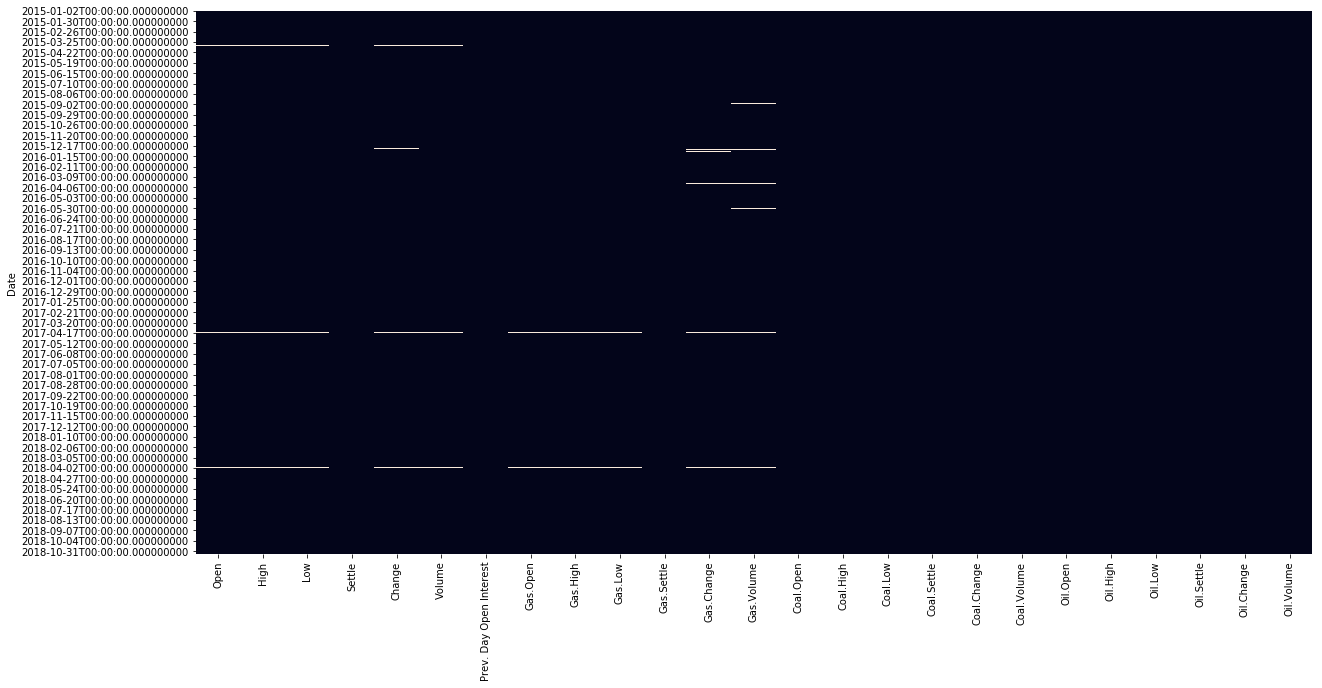

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
sns.heatmap(df.isnull(), cbar=False, ax=ax)

Data is missing on a few selected days, as it seems. For the purpose of this analysis, we can safely dropt these columns.

In [5]:
df = df.dropna(axis=0, how="any")

Next, we should plot our relevant data. Let us have a glance at a time series plot for some of the Settle values. Also, we will plot the Open, High, Low and Settle values for the ETS certificates.

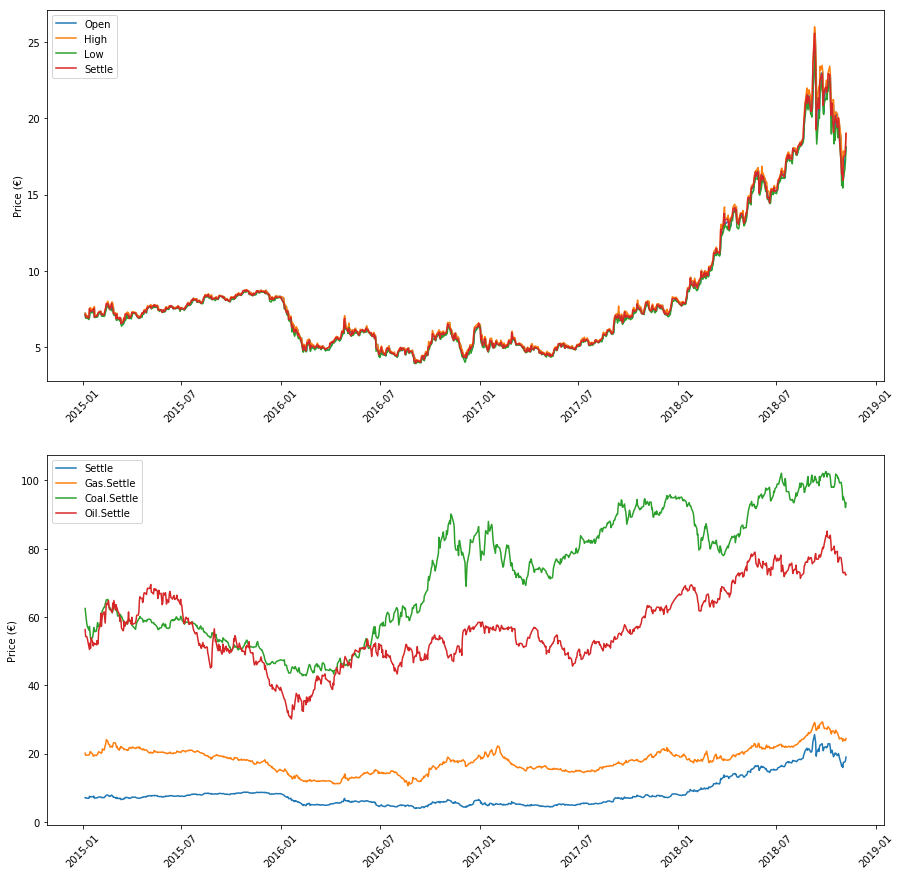

In [6]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))
ax1, ax2 = axes
for col in ["Open", "High", "Low", "Settle"]:
    ax1.plot(df.index, df[col])
    ax1.xaxis.set_tick_params(rotation=45)
    ax1.set_ylabel("Price (€)")
    ax1.legend()

for col in ["Settle", "Gas.Settle", "Coal.Settle", "Oil.Settle"]:
    ax2.plot(df.index, df[col])
    ax2.xaxis.set_tick_params(rotation=45)
    ax2.set_ylabel("Price (€)")  # ToDo: This is not actually € but $ for coal and oil. We need the daily exchange rate
    ax2.legend()

The graphs depict a strong relationship between Open, High, Low and Settle, meaning that the prices do not oscillate extraordinarily. Also, trends appear to be common between between all four.
Next, let us have a look at the univariate distributions of our features:

c:\program files\python36\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


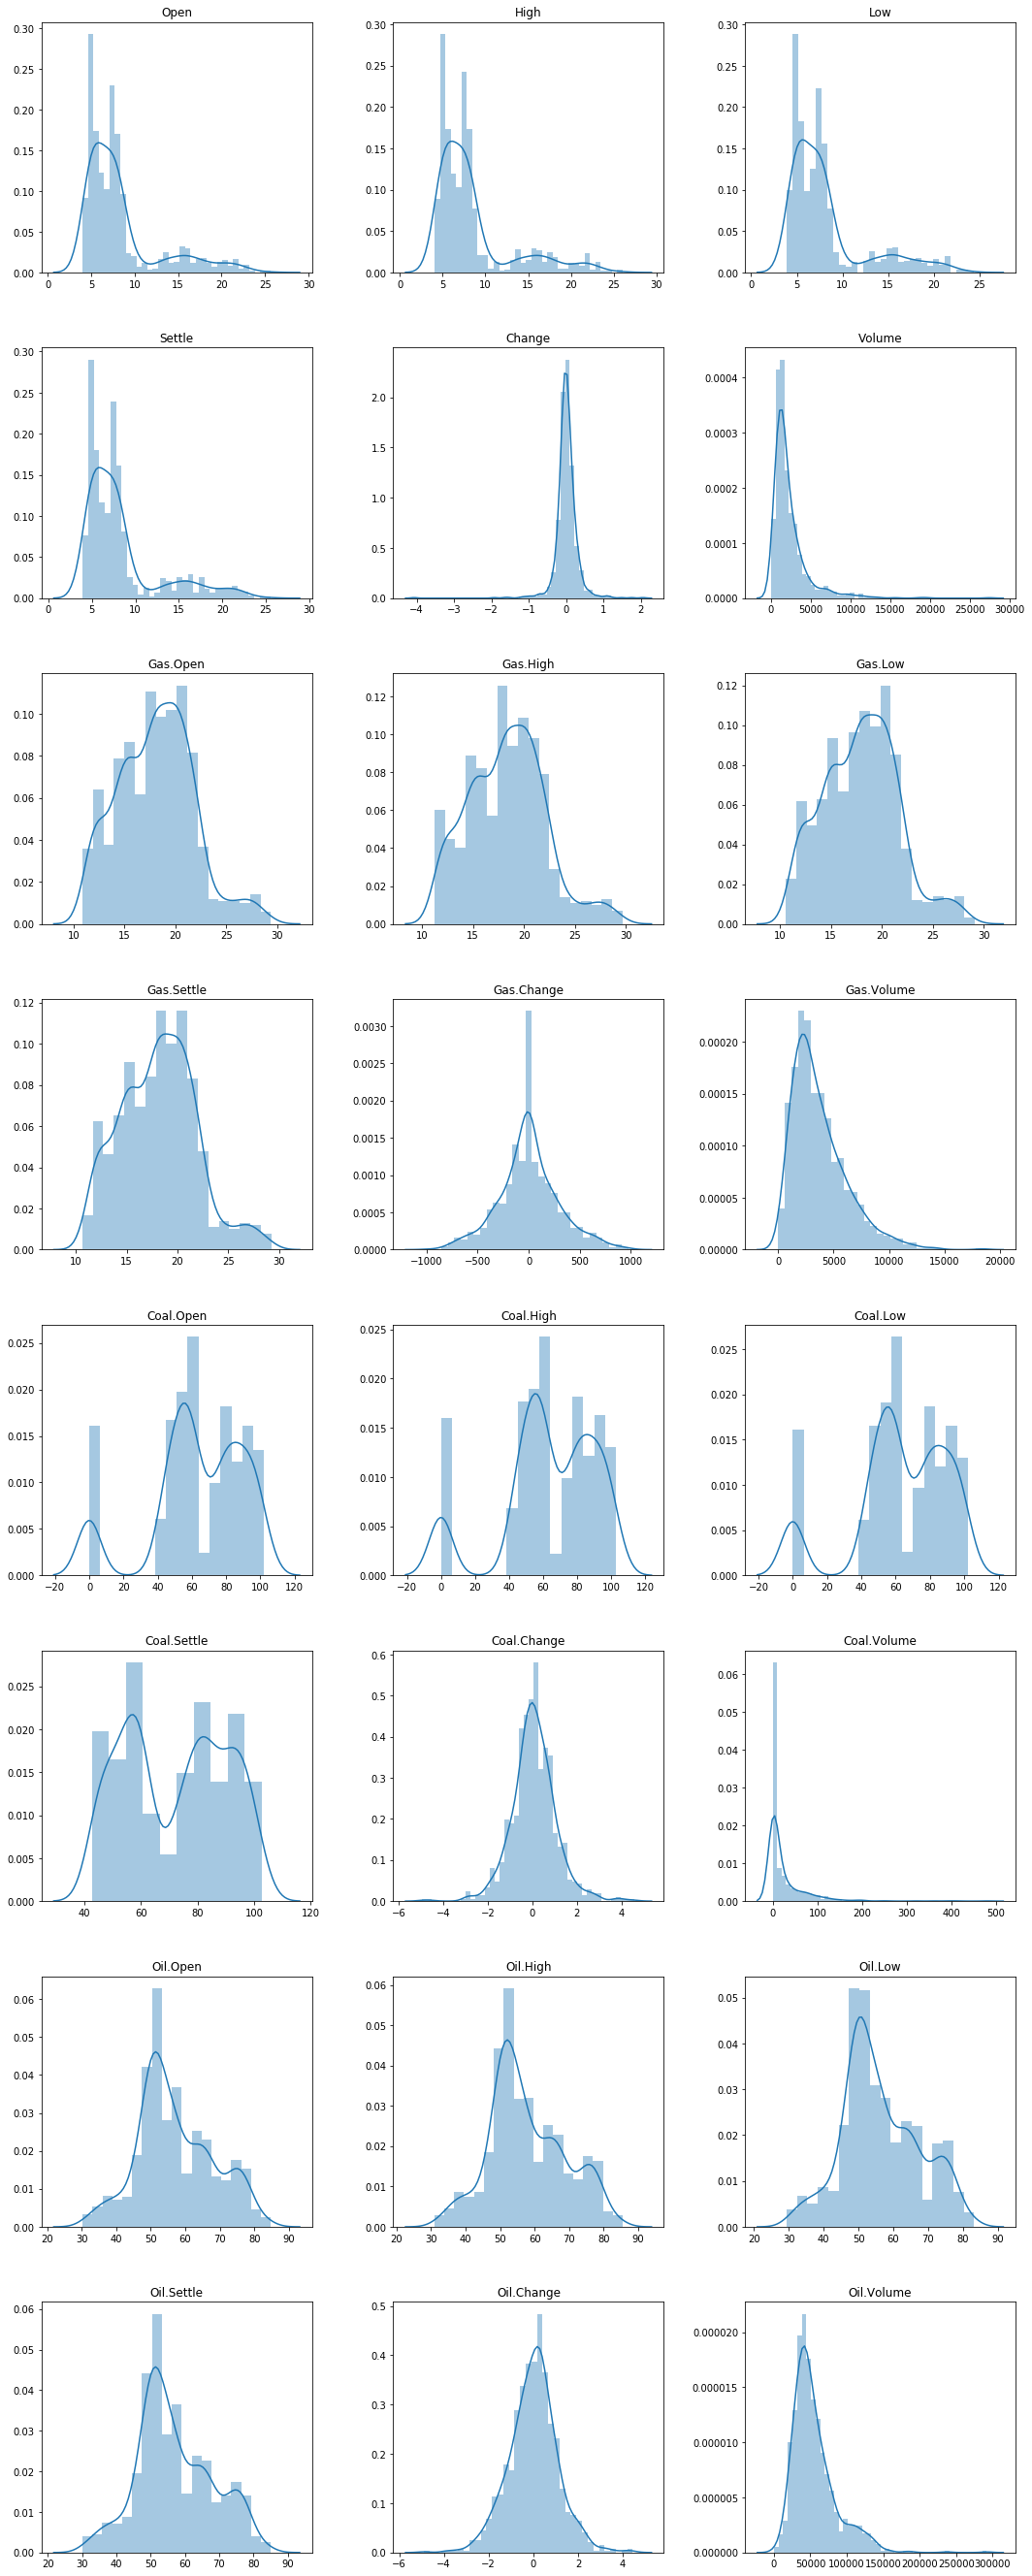

In [7]:
def plot_univariate_distributions(df, columns, ncols=3):
    """
    Make plots of the univariate distributions of the specified columns of a given dataframe.
    :param df: A pandas DataFrame instance
    :param columns: An iterable of strings indicating the desired columns of the dataframe to plot.
    :return: None
    """
    nrows = int(np.ceil(len(columns) / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 6, nrows * 6))
    axes = axes.reshape(-1, ncols)
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    last_used_col = 0
    for i, col in enumerate(columns):
        cur_col_number = i % ncols
        ax = axes[(i // ncols, cur_col_number)]
        sns.distplot(df[col].values, ax=ax)
        ax.set_title(col)
        last_used_col = cur_col_number
    for i in range(cur_col_number + 1, ncols):
        fig.delaxes(axes[-1, i])
        
columns = [col for col in df.columns if col != "Prev. Day Open Interest"]
plot_univariate_distributions(df, columns)
del columns

Prices appear to follow a lognormal distribution and changes generally look normal. However, for some reason, Gas.Change has an odd distribution. Its tails are extremely heavy, indicating there might be something wrong. The Gas.Change column represents the difference between Gas.Open and Gas.Settle, so it should not be nearly as large. For this reason, we will re-compute the .Change columns. Also, note that some of the coal values are actually zero. These are missing data, despite not being encoded as np.NaN. We will replace the open values by their respective previous settle values. For the maximum and minimum values, we will have to take the maximum and minimum of open and settle respectively. For volume, one could interpolate the values. We will, hovever, just drop the column for the time being.

In [8]:
missing_coal_rows = (df["Coal.Open"] <= 0)
df.loc[missing_coal_rows, "Coal.Open"] = (
    df["Coal.Settle"].asof(df[missing_coal_rows].index.shift(-1, freq="d")).shift(1, freq="d"))
del missing_coal_rows
coal_high_missing = (df["Coal.High"] <= 0)
df.loc[coal_high_missing, "Coal.High"] = np.max(df.loc[coal_high_missing, ["Coal.Open", "Coal.Settle"]], axis=1)
del coal_high_missing
coal_low_missing = (df["Coal.Low"] <= 0)
df.loc[coal_low_missing, "Coal.Low"] = np.min(df.loc[coal_low_missing, ["Coal.Open", "Coal.Settle"]], axis=1)
del coal_low_missing

Looking at the distributions once again, we find that the missing values are replaced:

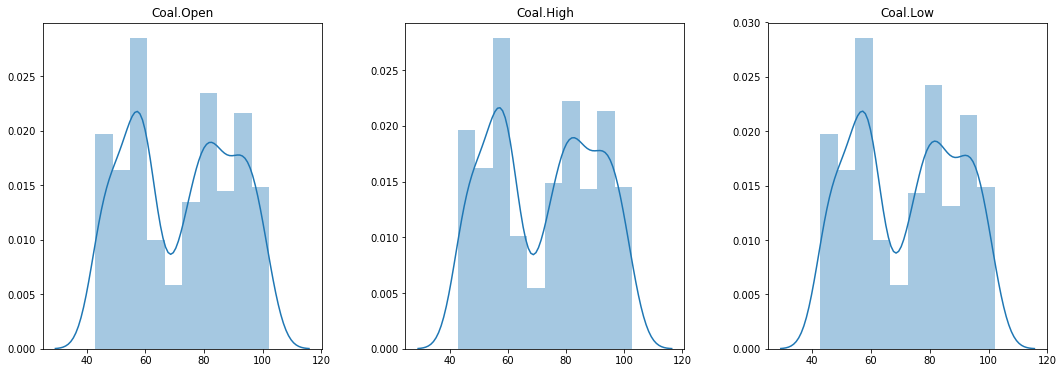

In [9]:
plot_univariate_distributions(df, ["Coal.Open", "Coal.High", "Coal.Low"])

In [10]:
change_cols = ["Change", "Gas.Change", "Coal.Change", "Oil.Change"]
open_cols = ["Open", "Gas.Open", "Coal.Open", "Oil.Open"]
settle_cols = ["Settle", "Gas.Settle", "Coal.Settle", "Oil.Settle"]
df[change_cols] = df[open_cols] - df[settle_cols].values

We can plot them again to look at how the distributions have changed:

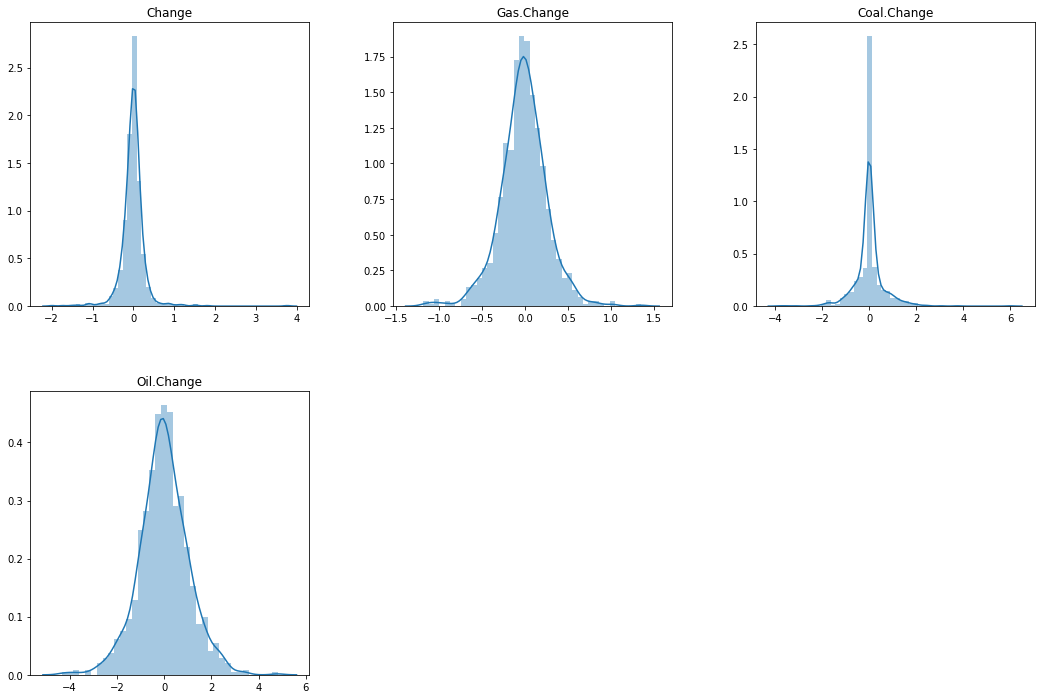

In [11]:
plot_univariate_distributions(df, ["Change", "Gas.Change", "Coal.Change", "Oil.Change"])

As we can easily see, the 
We continue by plotting the pairwise correlations of the data:

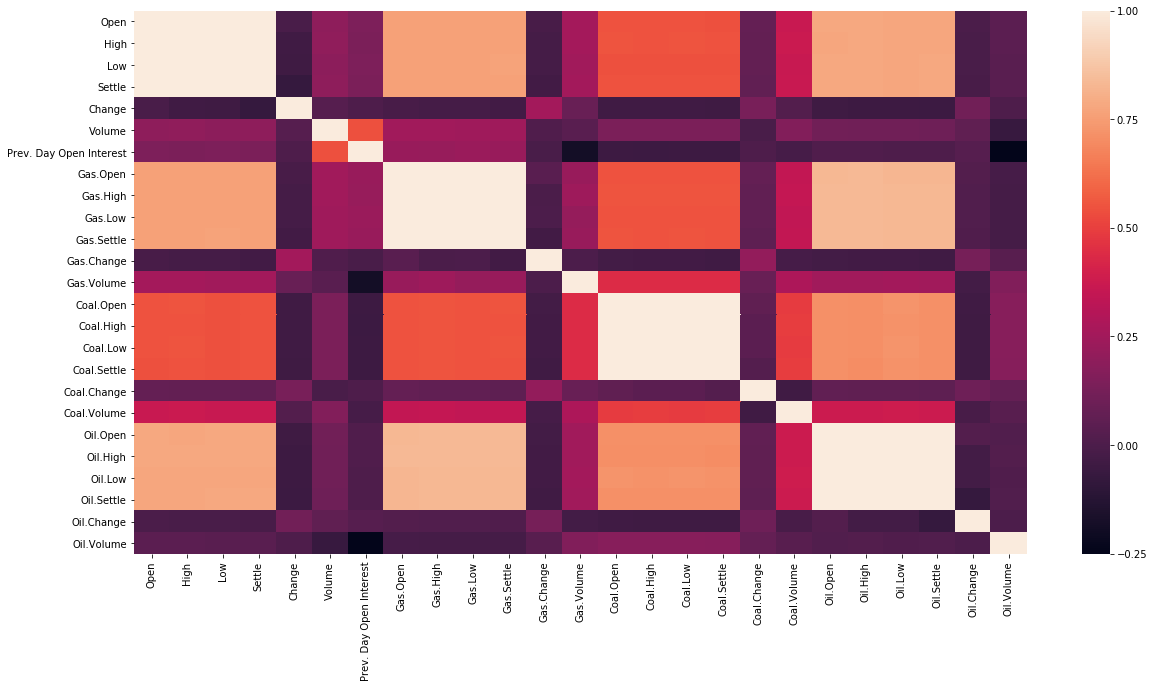

In [12]:
corr = df.corr()
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
sns.heatmap(corr, ax=ax,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

The pairwise correlation heatmap reveals that there are indeed quite a few linear relationships going on. The squares within the plot confirm the associations seen in the time series plots above. Correlations between the four types are large with coal being somewhat less correlated than the others, indicating that making good predictions on one of them will help with the others. A key insight here is that having information about changes in prices of oil, for example, will help with predicting the the EUA prices.